# Grid Proposals

## Vector Grids

In [21]:
#nbx --fname=../../../src/grid_proposals.jl
using Revise
using BenchmarkTools
using Colors, Plots, Images;
col = palette(:default);
(cgrad::PlotUtils.ContinuousColorGradient)(xs::Vector{Vector{Float64}}) = [cgrad[x] for x in xs];
(cgrad::PlotUtils.ContinuousColorGradient)(m::Matrix{Float64}) = reshape(cgrad[m[:]], size(m));
using Gen
using Fmt: @f_str, format # Python-style f-strings
using CUDA 

push!(LOAD_PATH, "../../../src");
using Pose2D: Pose
using Geometry: Segment
using MyUtils
using Raycaster
using SensorDistributions;

In [2]:
#nbx
"""
Discretize into bins of diameter r, bin-centers lie 
at `z - k*r` for intergers `k`.
"""
quantize(x, r; zero=0) = Int.(floor.((x .+ r./2 .- zero)./r))

quantize

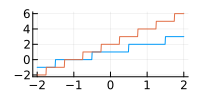

In [3]:
xs  = -2:0.01:2
# ----------------- 
plot(size=(200,100))
plot!(xs, quantize.(xs, 1.0; zero=-1), legend=nothing)
plot!(xs, quantize.(xs, 0.5; zero=-1), legend=nothing)

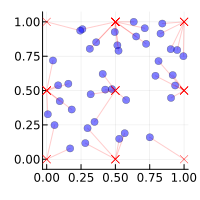

In [4]:
r  = [0.5, 0.5]
xs = unstack(rand(40,2))
is = quantize.(xs, [r])
# ------------------------
mypl = plot(size=(200,200), aspect_ratio=:equal, legend=nothing)
for (x,i) in zip(xs, is)
    y = i.*r
    plot!([x,y], c=:red, alpha=0.2)
    scatter!([x], c=:blue, alpha=0.5)
    scatter!([y], c=:red, marker=:x)
    
end
mypl

**Vector Grids.** In our context a *vector grid* is defined by a triple `(v0,k,r)`, where
-  `v0` is a vector defining the center of the grid,
-  `k` is a integer vector that contains the number of grid points in each dimension, and
-  `r` is a float vector that contains the resolution along each dimension.

In [5]:
#nbx
"""
    get_offset(v0, k, r)

Computes the offset to move the center 
of the grid to `v0`. The offset is a vector 
pointing to the lower-left corner of the grid.
"""
function get_offset(v0, k, r)
    center = (r + k.*r)/2
    return v0 - center
end

""""
   v1 = first_grid_vec(v0, k, r)

Returns the first vector in the grid, ie. for a given 
grid `vs` it computes vs[1].
"""
function first_grid_vec(v0::Vector{T}, k::Vector{Int}, r::Vector{T}) where T <: Real
    return r + get_offset(v0, k, r) 
end

"""
    vs, ls = vector_grid(v0, k, r)

Returns grid of vectors and their linear indices, given 
a grid center, numnber of grid points along each dimension and
the resolution along each dimension.
"""
function vector_grid(v0::Vector{Float64}, k::Vector{Int}, r::Vector{Float64})
    # Todo: Does it make sense to get a CUDA version of this?
    offset = get_offset(v0, k, r)
    
    shape = Tuple(k)
    cs = CartesianIndices(shape)
    vs = map(I -> [Tuple(I)...].*r + offset, cs);
    return vs
end


function grid_index(x, v0, k, r; linear=false)
    I = quantize(x, r, zero=get_offset(v0, k, r));
    I = CartesianIndex(I...)
    if linear
        shape = Tuple(k)
        I = LinearIndices(shape)[I] 
    end
    return I
end;


function grid_index(x, vs::AbstractArray; linear=false)
    r = vs[fill(2, ndims(vs))...] - vs[fill(1, ndims(vs))...]
    offset = vs[1] - r
    I = quantize(x, r, zero=offset);
    I = CartesianIndex(I...)
    if linear
        shape = size(vs)
        I = LinearIndices(shape)[I] 
    end
    return I
end;

In [6]:
v0 = rand(3)
k  = [12,10,7]
r  = [2.2,1.2,0.3]


offset = get_offset(v0, k, r)
vs     = vector_grid(v0, k, r);
v1     = first_grid_vec(v0, k, r)

3-element Vector{Float64}:
 -11.827055394918798
  -5.25648850072083
  -0.45949795235239904

(12, 10)
CartesianIndex(6, 6)


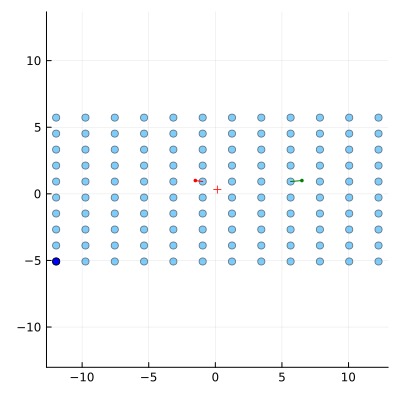

In [7]:
v0 = rand(2)
k  = [12,10]
r  = [2.2,1.2]

vs = vector_grid(v0, k, r);
v1 = first_grid_vec(v0, k, r)

x = [-1.5,1.]
y = [6.5,1.]

i = grid_index(x, v0, k, r; linear=false)
j = grid_index(y, vs; linear=false)

println(size(vs));
println(i)
# ------------------------
mypl = plot(size=(400,400), aspect_ratio=:equal, legend=nothing)
scatter!(vs[:], alpha=0.5)
scatter!([v0], c=:red, marker=:+)
scatter!([v1], c=:blue)

scatter!([x], markersize=2, markerstrokewidth=0, c=:red)
plot!([x,vs[i]], c=:red)
scatter!([y], markersize=2, markerstrokewidth=0, c=:green)
plot!([y,vs[j]], c=:green)
mypl 

In [8]:
v0 = rand(4)
k  = [10,10,10,10]
r  = [0.5,0.5,0.5,0.5]

x = rand(4)

@btime vector_grid(v0, k, r) samples=1 evals=3;
@btime grid_index(x, v0, k, r; linear=false) samples=1 evals=3;
@btime grid_index(x, v0, k, r; linear=true) samples=1 evals=3;

  2.064 ms (30013 allocations: 2.82 MiB)
  5.341 μs (7 allocations: 576 bytes)
  7.181 μs (10 allocations: 688 bytes)


## Eval Poses

In [43]:
#nbx
"""
    logps, outl = eval_pose_vectors(
                    vs   :: Array{Vector{Float64}},
                    z    :: Vector{Float64}, 
                    segs :: Vector{Segment}, 
                    fov, num_a, 
                    w::Int, sig, outlier, zmax::Float64=50.0; 
                    sorted = false)

Evaluates a collection of poses 
with respect to different Gaussian mixtures...
"""
function eval_pose_vectors(
            vs   :: Array{Vector{Float64}},
            z    :: Vector{Float64}, 
            segs :: Vector{Segment}, 
            fov, num_a::Int, w::Int, 
            sig, outlier, 
            zmax::Float64=50.0; 
            sorted=false, return_outliermap=false)
    
    ps   = stack(vs[:])
    segs = stack(Vector.(segs))
    as   = create_angles(fov, num_a)

    if _cuda[]
        ps   = CuArray(ps)
        z    = CuArray(z)
        segs = CuArray(segs)
        as   = CuArray(as)
    end
    
    zs = cast(ps, segs; fov=fov, num_a=num_a, zmax=zmax)
    ỹ, d̃ = get_1d_mixture_components(zs, as, w);

        
    # Evaluate the the observations with respect to the 
    # different Gaussian mixtures computed above
    logps,_, outl = depthdist_logpdf(z, ỹ, d̃, sig, outlier, zmax; 
                              scale_noise=false, 
                              return_pointwise=false, 
                              return_outliermap=return_outliermap);
    
    # Move everyting back to CPU 
    # if is not already there
    logps = Array(logps)
    if return_outliermap
        outl = Array(outl)
    end

    return logps, outl
end;

"""
    logps, outl = eval_pose_vectors(
                    vs   :: Array{Vector{Float64}},
                    z    :: Vector{Float64},
                    segs :: Vector{Segment},
                    fov, num_a::Int, w::Int,
                    sig     :: AbstractVector, 
                    outlier :: AbstractVector,
                    zmax::Float64=50.0
                    ;sorted=false, return_outliermap=false)

Evaluates a collection of poses 
with respect to different Gaussian mixtures...
"""
function eval_pose_vectors(
    vs   :: Array{Vector{Float64}},
    z    :: Vector{Float64},
    segs :: Vector{Segment},
    fov, num_a::Int, w::Int,
    sig::AbstractVector, 
    outlier::AbstractVector,
    zmax::Float64=50.0
    ;sorted=false, return_outliermap=false)

    if _cuda[]
        sig     = CuArray(sig)
        outlier = CuArray(outlier)
    end

    return eval_pose_vectors(vs, z, segs, fov, num_a, w, sig, outlier, zmax; 
            return_outliermap=return_outliermap)
end;


In [65]:
vs = vector_grid(v0, k, r);
size(vs)
vs[:][1]

3-element Vector{Float64}:
 -0.45000000000000007
 -0.45000000000000007
 -0.28274333882308134

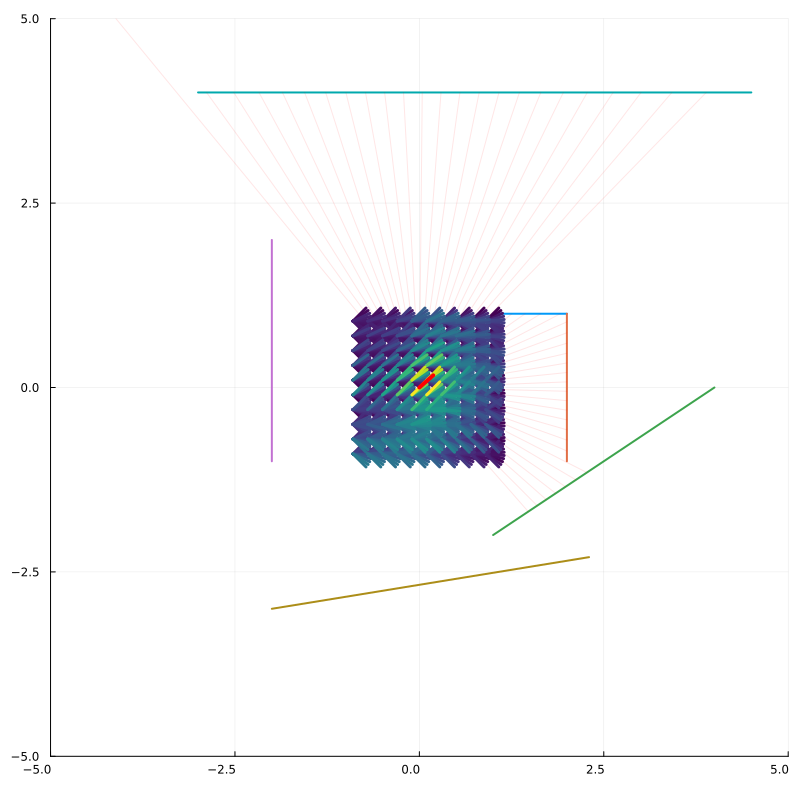

In [115]:
segs = Segment.([
    [1.,1.,2.,1.],
    [2.,1.,2.,-1.],
    [1.,-2.,4.,0.],
    [-2.,2.,-2.,-1.],
    [-2.,-3.,2.3,-2.3],
    [-3.,4.,4.5,4],
])

fov   = π
num_a = 100
w      = 10
zmax   = 10.

p  = stack([[0.0;0.0;rand()*π]])
as = create_angles(fov, num_a)

zs = cast(p, stack(Vector.(segs)); fov=fov, num_a=num_a, zmax=zmax)
z = zs[1,:]

v0 = zeros(3)
k  = [10,10,10]
r  = [.2,.2, 10/360*2π]

sig = 0.1
outlier = 0.1

vs = vector_grid(v0, k, r);


logps, = eval_pose_vectors(vs, z, segs, fov, num_a, w, sig, outlier, zmax)
sort_them!(logps, vs)

# ----------------------
mypl = plot(size=(800,800), aspect_ratio=:equal, legend=nothing, 
    xlim=(-5,5),
    ylim=(-5,5)
)
plot!(segs, cs=col[1:n], linewidth=2)
plot_rays!(Pose(p[1,:]), z, as; step=2, alpha=.1, c=:red)
plot!(Pose.(vs[:]), cgrad(:viridis)[peak_to_peak(logps)], r=0.25, linewidth=3)
plot!([Pose(p[1,:])], c=:red, r=0.25, linewidth=4)
mypl